# Getting started with neural networks: Classification and regression

## Classifying newswires: A multiclass classification example

### The Reuters dataset

#### Loading the Reuters dataset

In [21]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from torchtext.datasets import AG_NEWS
import matplotlib.pyplot as plt

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

trainset = AG_NEWS('./data', split='train')
testset = AG_NEWS('./data', split='test')

train_iter = iter(AG_NEWS(split='train'))
print(next(train_iter))
print(len(next(train_iter)[1])) # print the length of the sentence

(3, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")
266


In [3]:
tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(trainset), specials=["<unk>"], min_freq=50)
vocab.set_default_index(vocab["<unk>"])

print(vocab(['here', 'is', 'an', 'example']))

text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

print(text_pipeline('here is an example'))
print(label_pipeline('4'))

[475, 21, 30, 5297]
[475, 21, 30, 5297]
3


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        if sequence<10000:
            results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results


def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = text_pipeline(_text)
         processed_text = torch.tensor(vectorize_sequences(processed_text))
         processed_text = torch.sum(processed_text, dim=0)
         processed_text = torch.where(processed_text>0, torch.ones_like(processed_text), torch.zeros_like(processed_text))
        #  print(torch.tensor(_label).shape, processed_text.shape)
         text_list.append(processed_text.view(-1, 10000))
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    # print(len(text_list))
    text_list = torch.cat(text_list, dim=0).float()
    # print(text_list.shape)
    return label_list.to(device), text_list.to(device)#, offsets.to(device)

train_iter, test_iter = AG_NEWS()
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

split_train_, split_valid_ = \
    random_split(train_dataset, [60000, 60000])

train_dataloader = DataLoader(split_train_, batch_size=128,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=128,
                              shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=128,
                             shuffle=False, collate_fn=collate_batch)

cuda


### Building our network

In [6]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10000, 1024)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 256)
        self.act2 = nn.ReLU()
        # self.fc3 = nn.Linear(256, 256)
        # self.act3 = nn.ReLU()
        self.fc4 = nn.Linear(256, 4)
        # there is no softmax function since softmax function will be automatically applied inside of the cross-entropy loss provided by pytorch


    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        # x = self.act3(self.fc3(x))
        x = self.fc4(x)

        return x
        
model = Model()
model.to(device)

Model(
  (fc1): Linear(in_features=10000, out_features=1024, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (act2): ReLU()
  (fc4): Linear(in_features=256, out_features=4, bias=True)
)

In [7]:
optimizer = optim.RMSprop(params = model.parameters(), lr = 0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [8]:
history = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(10):
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    running_val_loss = 0.0
    running_val_correct = 0
    running_val_total = 0
    for i, data in enumerate(train_dataloader):
        # get the inputs; data is a list of [labels, inputs]
        labels, inputs = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # print(labels)
        # print(inputs.shape)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = outputs.max(dim=1)
        # print(preds)
        # print statistics
        running_loss += loss.item()
        running_correct += (preds == labels).sum()
        running_total += labels.size(0)
        # print(running_correct/running_total)


    for i, data in enumerate(valid_dataloader):
        labels, inputs = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = outputs.max(dim=1)

        running_val_loss += loss.item()
        running_val_correct += (preds == labels).sum()          
        running_val_total += labels.size(0)

    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / len(train_dataloader):.3f}, accuracy: {running_correct/running_total:.4f}, val_loss: {running_val_loss / len(valid_dataloader):.3f}, valid accuracy: {running_val_correct/running_val_total:.4f}')

    history['loss'].append(running_loss / len(train_dataloader))
    history['acc'].append((running_correct/running_total).item())
    history['val_loss'].append(running_val_loss / len(valid_dataloader))
    history['val_acc'].append((running_val_correct/running_val_total).item())

    # print(outputs)
print('Finished Training')

[1,   469] loss: 0.460, accuracy: 0.8749, val_loss: 0.294, valid accuracy: 0.9029
[2,   469] loss: 0.174, accuracy: 0.9436, val_loss: 0.340, valid accuracy: 0.8986
[3,   469] loss: 0.072, accuracy: 0.9775, val_loss: 0.481, valid accuracy: 0.9028
[4,   469] loss: 0.040, accuracy: 0.9892, val_loss: 0.588, valid accuracy: 0.9029
[5,   469] loss: 0.028, accuracy: 0.9933, val_loss: 0.739, valid accuracy: 0.9023
[6,   469] loss: 0.023, accuracy: 0.9946, val_loss: 0.751, valid accuracy: 0.9008
[7,   469] loss: 0.019, accuracy: 0.9955, val_loss: 0.927, valid accuracy: 0.9025
[8,   469] loss: 0.020, accuracy: 0.9962, val_loss: 0.983, valid accuracy: 0.9025
[9,   469] loss: 0.021, accuracy: 0.9956, val_loss: 1.057, valid accuracy: 0.8990
[10,   469] loss: 0.017, accuracy: 0.9962, val_loss: 0.932, valid accuracy: 0.9010
Finished Training


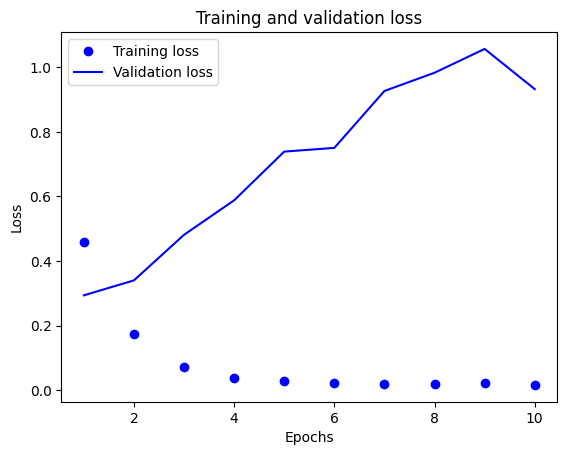

In [11]:
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

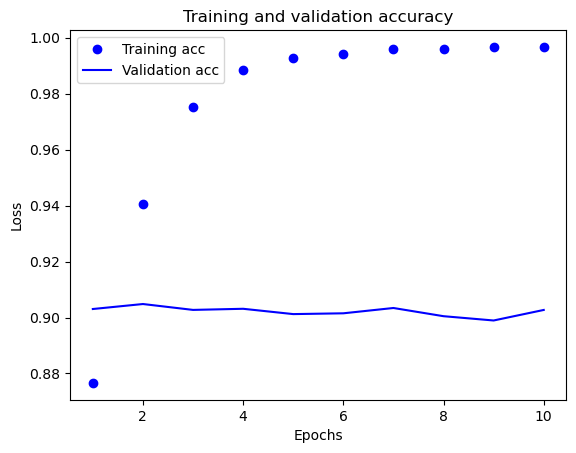

In [ ]:
plt.clf()   # clear figure

acc = history['acc']
val_acc = history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [12]:
running_test_loss = 0
running_test_correct = 0
running_test_total = 0


for i, data in enumerate(test_dataloader):
    labels, inputs = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = outputs.max(dim=1)

    running_test_loss += loss.item()
    running_test_correct += (preds == labels).sum()          
    running_test_total += labels.size(0)

print(f'test loss: {running_loss / len(test_dataloader):.3f}, test accuracy: {running_test_correct/running_test_total:.4f}')

test loss: 0.132, test accuracy: 0.8995


In [16]:
data = next(iter(test_dataloader))
labels, inputs = data
inputs = inputs.to(device)
labels = labels.to(device)

predictions = model(inputs)
print(predictions[0], predictions[0].shape)
softmax_predictions = torch.softmax(predictions, dim=1)
print(softmax_predictions[0], softmax_predictions[0].shape)

tensor([  5.2801, -29.8672,   6.9803, -22.5741], device='cuda:0',
       grad_fn=<SelectBackward0>) torch.Size([4])
tensor([1.5444e-01, 8.4032e-17, 8.4556e-01, 1.2354e-13], device='cuda:0',
       grad_fn=<SelectBackward0>) torch.Size([4])


### On the importance of having sufficiently large intermediate layers

In [17]:
import torch.nn as nn

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10000, 64)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 4)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(4, 4)
        # there is no softmax function since softmax function will be automatically applied inside of the cross-entropy loss provided by pytorch


    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        x = self.fc3(x)

        return x
        
model = Model()
model.to(device)

Model(
  (fc1): Linear(in_features=10000, out_features=64, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=64, out_features=4, bias=True)
  (act2): ReLU()
  (fc3): Linear(in_features=4, out_features=4, bias=True)
)

In [18]:
import torch.optim as optim

optimizer = optim.RMSprop(params = model.parameters(), lr = 0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [19]:
history = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(10):
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    running_val_loss = 0.0
    running_val_correct = 0
    running_val_total = 0
    for i, data in enumerate(train_dataloader):
        # get the inputs; data is a list of [labels, inputs]
        labels, inputs = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # print(labels)
        # print(inputs.shape)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = outputs.max(dim=1)
        # print(preds)
        # print statistics
        running_loss += loss.item()
        running_correct += (preds == labels).sum()
        running_total += labels.size(0)
        # print(running_correct/running_total)


    for i, data in enumerate(valid_dataloader):
        labels, inputs = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = outputs.max(dim=1)

        running_val_loss += loss.item()
        running_val_correct += (preds == labels).sum()          
        running_val_total += labels.size(0)

    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / len(train_dataloader):.3f}, accuracy: {running_correct/running_total:.4f}, val_loss: {running_val_loss / len(valid_dataloader):.3f}, valid accuracy: {running_val_correct/running_val_total:.4f}')

    history['loss'].append(running_loss / len(train_dataloader))
    history['acc'].append((running_correct/running_total).item())
    history['val_loss'].append(running_val_loss / len(valid_dataloader))
    history['val_acc'].append((running_val_correct/running_val_total).item())

    # print(outputs)
print('Finished Training')

[1,   469] loss: 0.371, accuracy: 0.8704, val_loss: 0.272, valid accuracy: 0.9074
[2,   469] loss: 0.193, accuracy: 0.9345, val_loss: 0.289, valid accuracy: 0.9063
[3,   469] loss: 0.110, accuracy: 0.9620, val_loss: 0.360, valid accuracy: 0.8962
[4,   469] loss: 0.058, accuracy: 0.9803, val_loss: 0.495, valid accuracy: 0.8973
[5,   469] loss: 0.034, accuracy: 0.9880, val_loss: 0.626, valid accuracy: 0.8989
[6,   469] loss: 0.026, accuracy: 0.9916, val_loss: 0.790, valid accuracy: 0.8972
[7,   469] loss: 0.020, accuracy: 0.9928, val_loss: 0.823, valid accuracy: 0.8981
[8,   469] loss: 0.016, accuracy: 0.9946, val_loss: 0.906, valid accuracy: 0.8956
[9,   469] loss: 0.016, accuracy: 0.9952, val_loss: 0.885, valid accuracy: 0.8947
[10,   469] loss: 0.013, accuracy: 0.9957, val_loss: 1.013, valid accuracy: 0.8976
Finished Training


### Additional Experiments

- LeakyReLU
- BatchNormalization
- optimizer - adam
- dropout
- one more layer

#### Experiment 1: LeakyReLU + BatchNormalization

In [55]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10000, 1024)
        self.act1 = nn.LeakyReLU()
        self.bn1 = nn.BatchNorm1d(1024)
        
        self.fc2 = nn.Linear(1024, 256)
        self.act2 = nn.LeakyReLU()
        self.bn2 = nn.BatchNorm1d(256)
        
        # self.fc3 = nn.Linear(256, 256)
        # self.act3 = nn.ReLU()
        self.fc4 = nn.Linear(256, 4)
        # there is no softmax function since softmax function will be automatically applied inside of the cross-entropy loss provided by pytorch


    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.bn1(x)
        
        x = self.act2(self.fc2(x))
        x = self.bn2(x)
        
        # x = self.act3(self.fc3(x))
        x = self.fc4(x)

        return x
        

model = Model()
model.to(device)

Model(
  (fc1): Linear(in_features=10000, out_features=1024, bias=True)
  (act1): LeakyReLU(negative_slope=0.01)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (act2): LeakyReLU(negative_slope=0.01)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=256, out_features=4, bias=True)
)

Change Activation function to SGD

In [35]:
optimizer = optim.SGD(params = model.parameters(), lr = 0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [36]:
history = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(5):
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    running_val_loss = 0.0
    running_val_correct = 0
    running_val_total = 0
    for i, data in enumerate(train_dataloader):
        # get the inputs; data is a list of [labels, inputs]
        labels, inputs = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # print(labels)
        # print(inputs.shape)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = outputs.max(dim=1)
        # print(preds)
        # print statistics
        running_loss += loss.item()
        running_correct += (preds == labels).sum()
        running_total += labels.size(0)
        # print(running_correct/running_total)


    for i, data in enumerate(valid_dataloader):
        labels, inputs = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = outputs.max(dim=1)

        running_val_loss += loss.item()
        running_val_correct += (preds == labels).sum()          
        running_val_total += labels.size(0)

    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / len(train_dataloader):.3f}, accuracy: {running_correct/running_total:.4f}, val_loss: {running_val_loss / len(valid_dataloader):.3f}, valid accuracy: {running_val_correct/running_val_total:.4f}')

    history['loss'].append(running_loss / len(train_dataloader))
    history['acc'].append((running_correct/running_total).item())
    history['val_loss'].append(running_val_loss / len(valid_dataloader))
    history['val_acc'].append((running_val_correct/running_val_total).item())

    # print(outputs)
print('Finished Training')

[1,   469] loss: 0.437, accuracy: 0.8464, val_loss: 0.314, valid accuracy: 0.8923
[2,   469] loss: 0.185, accuracy: 0.9422, val_loss: 0.299, valid accuracy: 0.8972
[3,   469] loss: 0.085, accuracy: 0.9789, val_loss: 0.309, valid accuracy: 0.8984
[4,   469] loss: 0.035, accuracy: 0.9949, val_loss: 0.322, valid accuracy: 0.9010
[5,   469] loss: 0.018, accuracy: 0.9978, val_loss: 0.340, valid accuracy: 0.9019
Finished Training


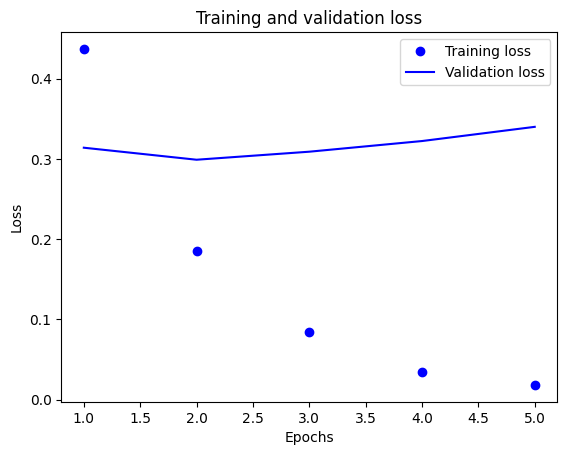

In [37]:
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

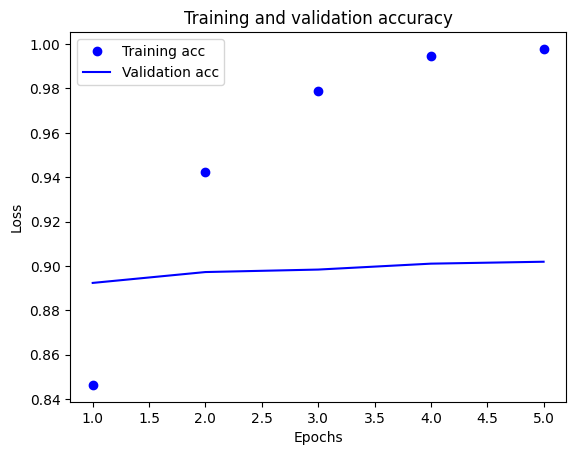

In [38]:
plt.clf()   # clear figure

acc = history['acc']
val_acc = history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [39]:
running_test_loss = 0
running_test_correct = 0
running_test_total = 0


for i, data in enumerate(test_dataloader):
    labels, inputs = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = outputs.max(dim=1)

    running_test_loss += loss.item()
    running_test_correct += (preds == labels).sum()          
    running_test_total += labels.size(0)

print(f'test loss: {running_loss / len(test_dataloader):.3f}, test accuracy: {running_test_correct/running_test_total:.4f}')

test loss: 0.144, test accuracy: 0.8925


#### Experiment 2: One more Layer + ReLU + Dropout(0.3)

In [58]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10000, 1024)
        self.act1 = nn.ReLU()
        self.BatchNorm1d1 = nn.BatchNorm1d(1024, affine=False) # Batch Normalization 추가
        self.drop1 = nn.Dropout(0.3) # Dropout 추가
        
        self.fc2 = nn.Linear(1024, 256)
        self.act2 = nn.ReLU()
        self.BatchNorm1d2 = nn.BatchNorm1d(256, affine=False) # Batch Normalization 추가
        self.drop2 = nn.Dropout(0.3) # Dropout 추가
        
        self.fc3 = nn.Linear(256, 256)
        self.act3 = nn.ReLU()
        self.BatchNorm1d3 = nn.BatchNorm1d(256, affine=False) # Batch Normalization 추가
        
        self.fc4 = nn.Linear(256, 4)
        # there is no softmax function since softmax function will be automatically applied inside of the cross-entropy loss provided by pytorch


    def forward(self, x):
        x = self.drop1(self.BatchNorm1d1(self.act1(self.fc1(x))))
        x = self.drop2(self.BatchNorm1d2(self.act2(self.fc2(x))))
        x = self.BatchNorm1d3(self.act3(self.fc3(x)))
        x = self.fc4(x)

        return x
        
model = Model()
model.to(device)

Change optimizer to Adam

In [59]:
optimizer = optim.Adam(params = model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

In [60]:
history = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(5):
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    running_val_loss = 0.0
    running_val_correct = 0
    running_val_total = 0
    for i, data in enumerate(train_dataloader):
        # get the inputs; data is a list of [labels, inputs]
        labels, inputs = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # print(labels)
        # print(inputs.shape)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = outputs.max(dim=1)
        # print(preds)
        # print statistics
        running_loss += loss.item()
        running_correct += (preds == labels).sum()
        running_total += labels.size(0)
        # print(running_correct/running_total)


    for i, data in enumerate(valid_dataloader):
        labels, inputs = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = outputs.max(dim=1)

        running_val_loss += loss.item()
        running_val_correct += (preds == labels).sum()          
        running_val_total += labels.size(0)

    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / len(train_dataloader):.3f}, accuracy: {running_correct/running_total:.4f}, val_loss: {running_val_loss / len(valid_dataloader):.3f}, valid accuracy: {running_val_correct/running_val_total:.4f}')

    history['loss'].append(running_loss / len(train_dataloader))
    history['acc'].append((running_correct/running_total).item())
    history['val_loss'].append(running_val_loss / len(valid_dataloader))
    history['val_acc'].append((running_val_correct/running_val_total).item())

    # print(outputs)
print('Finished Training')

[1,   469] loss: 0.346, accuracy: 0.8798, val_loss: 0.285, valid accuracy: 0.9013
[2,   469] loss: 0.166, accuracy: 0.9399, val_loss: 0.305, valid accuracy: 0.9023
[3,   469] loss: 0.089, accuracy: 0.9674, val_loss: 0.377, valid accuracy: 0.8968
[4,   469] loss: 0.062, accuracy: 0.9773, val_loss: 0.430, valid accuracy: 0.8950
[5,   469] loss: 0.046, accuracy: 0.9840, val_loss: 0.467, valid accuracy: 0.8969
Finished Training


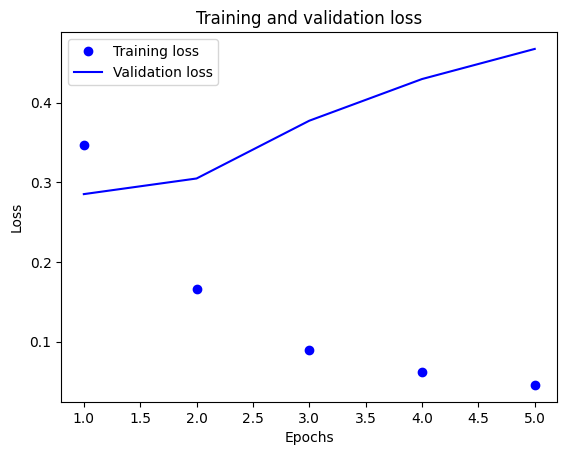

In [61]:
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

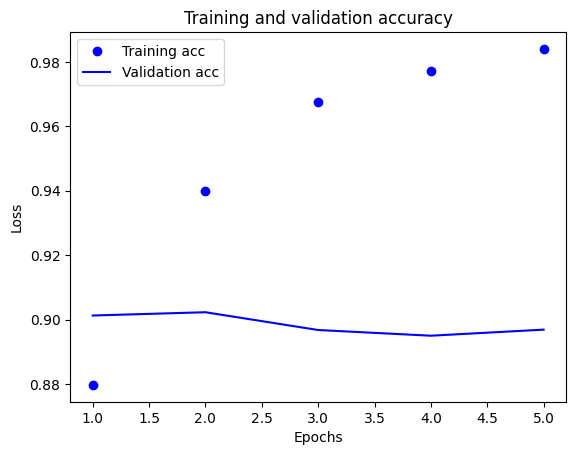

In [62]:
plt.clf()   # clear figure

acc = history['acc']
val_acc = history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [63]:
running_test_loss = 0
running_test_correct = 0
running_test_total = 0


for i, data in enumerate(test_dataloader):
    labels, inputs = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = outputs.max(dim=1)

    running_test_loss += loss.item()
    running_test_correct += (preds == labels).sum()          
    running_test_total += labels.size(0)

print(f'test loss: {running_loss / len(test_dataloader):.3f}, test accuracy: {running_test_correct/running_test_total:.4f}')

test loss: 0.357, test accuracy: 0.8913
